## Figure 4 (c) - Conceptual Model of the Magmatic-Hydrothermal System



In [1]:
%matplotlib inline
import os
import h5py
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt, ticker
from mintpy.utils import ptime, readfile, writefile, utils as ut, plot as pp
from mintpy.defaults.plot import *
from mintpy import mask, save_gmt, view

work_dir = os.path.expanduser('~/Papers/2021_Kirishima/figs_src/conceptual_model')
os.chdir(work_dir)
print('Go to directory', work_dir)

# convert DEM unit from m to km.
dem_int_file = os.path.expanduser('~/Papers/2021_Kirishima/figs_src/data/dem.wgs84')
dem_file = os.path.join(work_dir, 'dem.h5')
if not os.path.isfile(dem_file):
    dem, atr = readfile.read(dem_int_file)
    dem = np.array(dem, dtype=np.float32)
    dem /= 1000   #km
    writefile.write(dem, dem_file, atr)


## Coordinate Setting

# 1. bounding gox
lat0, lat1 = 31.89, 32.00
lon0, lon1 = 130.80, 130.92

# 2. transection location
profile_lalos = [
    [31.9460, 130.8100],    #[31.9290, 130.8130],
    [31.9460, 130.8524],    #[31.9470, 130.8535],
    [31.8594, 130.9292],    #[31.8500, 130.9350],
]

Go to directory /Users/yunjunz/Papers/2021_Kirishima/figs_src/conceptual_model


### 1. Prepare profile_sea_level.xyz for GMT/psxyz

In [2]:
## Get transection interception at the bounding box: [xb1, yb1] and [xb2, yb2]
# line 1
y0, x0 = profile_lalos[0]
y1, x1 = profile_lalos[1]
a = (y1 - y0) / (x1 - x0)
b = y0 - a * x0
xb1 = lon0
yb1 = a * xb1 + b
print('intercept at lat/lon: {:.4f}/{:.4f}'.format(yb1, xb1))

# line 1
y0, x0 = profile_lalos[1]
y1, x1 = profile_lalos[2]
a = (y1 - y0) / (x1 - x0)
b = y0 - a * x0
yb2 = lat0
xb2 = (yb2 - b) / a
print('intercept at lat/lon: {:.4f}/{:.4f}'.format(yb2, xb2))

# write points of interest to txt file for GMT
xy_list = []
xy_list.append([lon0, lat1])
xy_list.append([xb1, yb1])
xy_list.append([profile_lalos[1][1], profile_lalos[1][0]])
xy_list.append([xb2, yb2])
xy_list.append([lon1, lat0])

xyz_file = os.path.abspath('profile_sea_level.xyz')
with open(xyz_file, 'w') as f:
    f.write('>\n')
    for xy in xy_list:
        f.write('{:.4f}\t{:.4f}\t\t0\n'.format(xy[0], xy[1]))
print('finished writing to {}'.format(xyz_file))

intercept at lat/lon: 31.9460/130.8000
intercept at lat/lon: 31.8900/130.9021
finished writing to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/profile_sea_level.xyz


### 2. Cut DEM file for GMT/grdview

delete exsited file: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/maskCut.h5
create HDF5 file: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/maskCut.h5 with w mode
create dataset /.wgs84 of bool       in size of (3600, 5400)         with compression=None
finished writing to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/maskCut.h5
masking .wgs84 from dem.h5 ...
delete exsited file: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/dem_msk.h5
create HDF5 file: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/dem_msk.h5 with w mode
create dataset /.wgs84 of float32    in size of (3600, 5400)         with compression=None
finished writing to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/dem_msk.h5
Done.


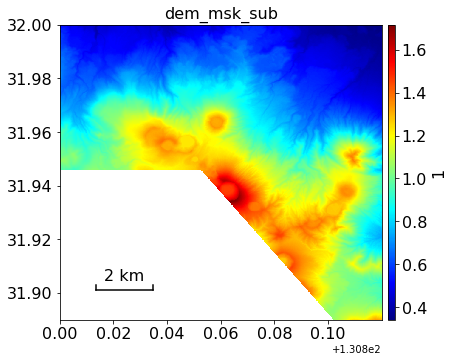

writing >>> dem_msk.grd
Done.


'dem_msk.grd'

In [3]:
# 1. prepare cut mask
atr = readfile.read_attribute(dem_file)
coord = ut.coordinate(atr)

length, width = int(atr['LENGTH']), int(atr['WIDTH'])
yy, xx = np.mgrid[0:length-1:length*1j, 0:width-1:width*1j].astype(np.int16)

line_pars = []
msk = np.ones((length, width), np.int16)
for i in range(len(profile_lalos)-1):
    # convert lalo to yx
    y0, x0 = coord.geo2radar(profile_lalos[i][0], profile_lalos[i][1])[0:2]
    y1, x1 = coord.geo2radar(profile_lalos[i+1][0], profile_lalos[i+1][1])[0:2]

    # calculate the line parameter
    a = (y1 - y0) / (x1 - x0)
    b = y0 - a * x0
    line_pars.append([a, b])

    # update mask
    msk *= yy > a * xx + b
msk = msk == 0

# 2. write cut mask to file
msk_file = os.path.abspath('maskCut.h5')
writefile.write(msk, msk_file, atr)

# 3. mask dem file
dem_msk_file = os.path.abspath('dem_msk.h5')
scp_args = 'dem.h5 -m {} -o {}'.format(msk_file, dem_msk_file)
mask.main(scp_args.split())

# 3.1 plot dem file 130.8/130.91/31.86/32.0
scp_args = '{} --figsize 6 8 --sub-lat 31.89 32.0 --sub-lon 130.8 130.92 --noverbose '.format(dem_msk_file)
view.main(scp_args.split())

# 4. convert to GMT format
save_gmt.main(['dem_msk.h5'])

### 3. Run GMT script ([doc](https://docs.generic-mapping-tools.org/5.4/grdview.html))

In [4]:
!./dem3D.sh

grdview: Read intensity grid header from file topo_i.nc
grdview: The y-coordinates and range attribute are in conflict; must rely on coordinates only
grdview: Guessing of registration in conflict between x and y, using gridline
grdview: Processing shape grid
grdview: Processing illumination grid
grdview: Start creating PostScript plot
grdview: Get and store projected vertices
grdview: Start rasterization
grdview: Creating PostScript image [color image]
grdview: Done!
psxyz: Processing input table data


<p align="left">
  <img width="600" src="conceptual_model/dem3D.png">
</p>     

### 4. Create 3D sources using Adobe Illustrator:   

<p align="left">
  <img width="500" src="conceptual_model/AI_source3D.png">
</p> 
<br>

Below are tutorial links and 3D configuration used:

a. Cuboid: https://www.webfx.com/blog/web-design/create-a-3d-shipping-package-box-icon-in-illustrator/  
b. Sphere: http://www.adobepress.com/articles/article.asp?p=1339477&seqNum=4

<p align="left">
  <img width="900" src="conceptual_model/AI_source3D_config.png">
</p> 

### 2D version - Topographic Profile (obsolete)

segment max distance: 3998.8 m
segment max distance: 16060.5 m
save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/topo_transect.png


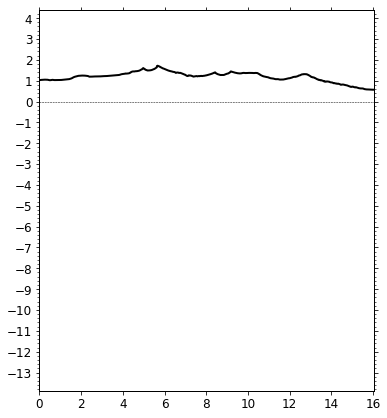

In [5]:
## Read DEM transection
dem, atr = readfile.read(dem_file)
transect = {}
start_distance = 0
for i in range(len(profile_lalos)-1):
    lalo0 = profile_lalos[i]
    lalo1 = profile_lalos[i+1]
    seg = ut.transect_lalo(dem, atr, start_lalo=lalo0, end_lalo=lalo1)
    seg['distance'] += start_distance
    print('segment max distance: {:.1f} m'.format(np.max(seg['distance'])))

    # add segment to transection
    if i == 0:
        transect['value'] = np.array(seg['value'], dtype=np.float32)
        transect['distance'] = np.array(seg['distance'], dtype=np.float32)
    else:
        transect['value'] = np.concatenate((transect['value'], seg['value'][1:]))
        transect['distance'] = np.concatenate((transect['distance'],seg['distance'][1:]))

    # update start_distance for the next segment
    start_distance = transect['distance'][-1]

transect['distance'] /= 1000.  #km

## plot
fig, ax = plt.subplots(figsize=[6,7])
ax.plot(transect['distance'], transect['value'], c='k', lw=2)
ax.axhline(0, ls='--', c='k', lw=0.5)

# axis format
ax.set_aspect('equal', 'datalim')
ax.set_ylim(-11.5, 2)
ax.set_xlim(0,np.max(transect['distance']))

#ax.set_ylabel('Depth [km]', fontsize=font_size)
ax.tick_params(which='both', direction='out', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

# output
out_file = os.path.abspath('topo_transect.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()